# PQ-Grams Distance vs. Fanout Weighted Tree Edit Distance

In the paper, the abstract makes the claim that PQ-Grams is a lower bound on the Fanout Weighted Tree Edit Distance (FWTED). However, once you dig into it, this appears only to be true for `p=1` and a carefully offset FWTED based on `q`.

And so, this notebook experimentally investigates the behavior of PQ-Grams distances as a function of increasing `p` value in relation the the FWTED.

As an aside, even though the FWTED appears to be invented by the authors so that the lower bound claim can be made, I found the arguments for using it as a distance metric to be compelling. I feel they could have easily spent an entire (short) paper investigating its properties more deeply. But I digress.

## Setup
We begin by generating a batch of random trees with:
- up to two children per node,
- minimum tree height of three
- maximum tree height of five

Those trees are then randomly edited so that we have a large number of trees with Tree Edit Distances (TEDs) of up to 10.

In [1]:
from collections import defaultdict
import random

from tqdm.notebook import tqdm

from tree import random_tree
from edit_tree import with_random_edit
from zhang_shasha import zhang_shasha

FANOUTS = (0,1,1,2,2,2,2,2)
NUM_PER_LAYER = 50

random.seed(hash("pq_grams"))

trees = [random_tree(min_height=3, max_depth=5, fanouts=FANOUTS) for _ in range(NUM_PER_LAYER)]
source_indexes: dict[int, int] = {i: i for i in range(len(trees))}
trees_by_edit_distance: defaultdict[int, list[int]] = defaultdict(list)
trees_by_edit_distance[0] = list(range(len(trees)))

for target_distance in tqdm(range(0, 10)):
    assert target_distance in trees_by_edit_distance
    maybe_edit_trees = trees_by_edit_distance[target_distance]
    for i in range(NUM_PER_LAYER):
        tree_index = random.choice(maybe_edit_trees)
        source_index = source_indexes[tree_index]
        
        tree = trees[tree_index]
        source = trees[source_index]
        
        edited, msg = with_random_edit(tree)
        
        distance = zhang_shasha(source, edited)
        assert distance.is_integer(), distance
        edited_index = len(trees)
        trees_by_edit_distance[int(distance)].append(edited_index)
        source_indexes[edited_index] = source_index
        trees.append(edited)
        


  0%|          | 0/10 [00:00<?, ?it/s]

## Fanout weighted tree edit distance
The `fwted` function implements the paper's proposed FWTED. In claiming that the PQ-Grams distance is a lower bound of FWTED, the FWTED is adjusted based on the `q` value chosen of the PQ-Grams distance.

In [2]:
from tree import TreeNode
from zhang_shasha import zhang_shasha, CostFunctions

def fwted(a_tree: TreeNode, b_tree: TreeNode, *, q: int) -> float:
    """Fanout weight tree edit distance.

    Ensures:
    - Alignment (edit) costs (Definition 5.4):
        Insert: f_v + c
        Delete: f_v' + c
        Relabel: (f_v + f_v')/2 + c
      where f_v and f_v' are the fanouts of a_tree's and b_tree's nodes, respectively;
      c is the constant cost offset used (see below).
    - The minimum constant cost offset is chosen (Theorem 7.4, Section 7.3):
        c = max(2*q - 1, 2)
      such that the pq-grams distance is a lower bound on this distance for p=1
    """
    cost_offset = max(2 * q - 1, 2)

    def insert_or_delete(node: TreeNode):
        return len(node.children) + cost_offset

    def relabel(a: TreeNode, b: TreeNode):
        if a.label == b.label:
            return 0.0
        return (len(a.children) + len(b.children)) / 2 + cost_offset

    cost_funcs = CostFunctions(insert=insert_or_delete, delete=insert_or_delete, relabel=relabel)

    return zhang_shasha(a_tree, b_tree, cost_funcs=cost_funcs)

## PQ-Grams distance
Here, we calculate the PQ-Grams distance of all the trees with varying `p` values. We record the difference of the PQ-Grams distance with the FWTED. These are all binned by the original TED just to give a better idea of how the differences grow with each other.

In [3]:
from dataclasses import dataclass
from pq_grams import pq_grams
from tqdm.notebook import tqdm

@dataclass
class PQDistance:
    min_delta_pq: defaultdict[int, float]
    max_delta_pq: defaultdict[int, float]
    fwted_weight: defaultdict[int, int]
    fwted_sum: defaultdict[int, float]
    
    def __init__(self) -> None:
        self.min_delta_pq = defaultdict(lambda: float("inf"))
        self.max_delta_pq = defaultdict(lambda: float("-inf"))
        self.fwted_weight = defaultdict(int)
        self.fwted_sum = defaultdict(float)
    
    def add(self, ted: int, fanout_weighted_distance: float, pq_distance: float):
        delta_pq = pq_distance - fanout_weighted_distance
        self.min_delta_pq[ted] = min(self.min_delta_pq[ted], delta_pq)
        self.max_delta_pq[ted] = max(self.max_delta_pq[ted], delta_pq)
        self.fwted_weight[ted] += 1
        self.fwted_sum[ted] += fanout_weighted_distance
    
    def distances(self) -> list[int]:
        return sorted(self.min_delta_pq)

    def min_delta_pqs(self) -> list[float]:
        return [self.min_delta_pq[distance] for distance in self.distances()]
    
    def max_delta_pqs(self) -> list[float]:
        return [self.max_delta_pq[distance] for distance in self.distances()]
    
    def mean_fwted(self) -> list[float]:
        return [self.fwted_sum[distance] / self.fwted_weight[distance] for distance in self.distances()]

pq_distances: defaultdict[int, PQDistance] = defaultdict(PQDistance)

q_value = 2

distances = sorted(trees_by_edit_distance.keys())

for p in tqdm(range(1, 5)):
    for distance in tqdm(distances, leave=False):
        edit_trees = trees_by_edit_distance[distance]
        for tree_index in edit_trees:
            tree = trees[tree_index]
            source_index = source_indexes[tree_index]
            source = trees[source_index]
            pq_distance = pq_grams(source, tree, p=p, q=q_value)
            fanout_weighted_distance = fwted(source, tree, q=q_value)
            
            pq_distances[p].add(distance, fanout_weighted_distance, pq_distance)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

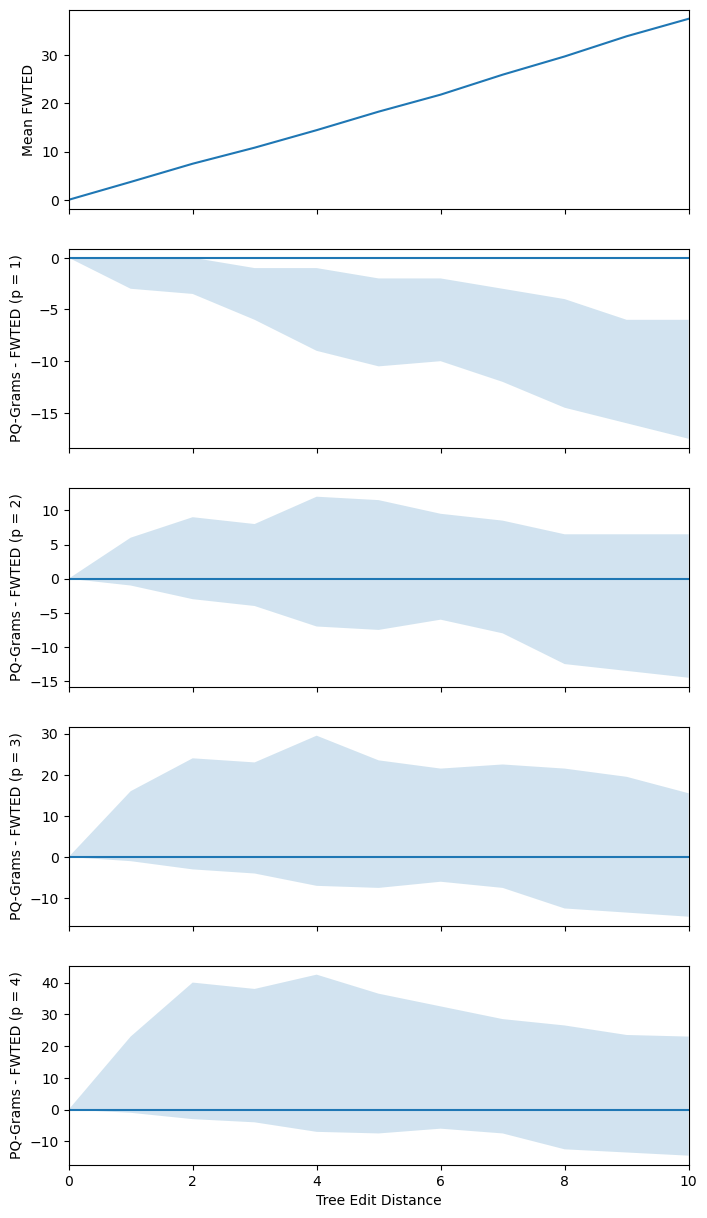

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(pq_distances) + 1, sharex=True, figsize=(8, 15))
for i, (p, pq_distance) in enumerate(sorted(pq_distances.items())):
    distances = pq_distance.distances()
    min_pq = pq_distance.min_delta_pqs()
    max_pq = pq_distance.max_delta_pqs()
    ax = axs[i + 1]
    ax.fill_between(distances, min_pq, max_pq, alpha=0.2)  # type: ignore
    ax.axhline(y=0)
    ax.set_ylabel(f"PQ-Grams - FWTED (p = {p})")
    
ax.set_xlabel("Tree Edit Distance")
    
distances = pq_distances[1].distances()
axs[0].plot(distances, pq_distances[1].mean_fwted())
axs[0].set_xlim(0, max(distances))
axs[0].set_ylabel("Mean FWTED")

plt.show()


## Results + Discussion

In the above plot the shaded regions are the min/max difference between the PQ-Grams distance and the FWTED. The solid line represents the FWTED; in the first plot this is its actual value, in the following plots this is just the x-axis to show that the PQ-Grams distances are relative.

We see that for `p=1` the PQ-Grams distance is indeed a lower bound for the FWTED. However, this breaks down as soon as `p>=2`. Perhaps there's a way to tune the FWTED based on `p` so that PQ-Grams is still a lower bound, but I would worry about how useful that would be in practice.

It seems that there is some real value in PQ-Grams when `p=1`. Being a very efficient way to calculate the lower bound for a (likely) useful distance metric is great. I wonder whether the paper should have been called "1Q-Grams" and focused its efforts there.

